# Employee Attrition Prediction with XGBoost
## Complete Analysis Pipeline

## 1. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("✓ Libraries loaded")

C:\Users\pierr\AppData\Local\Temp\ipykernel_8736\1279092019.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


✓ Libraries loaded


## 2. Load Data

In [3]:
print("Loading data...\n")

general = pd.read_csv("general_data.csv")
emp_survey = pd.read_csv("employee_survey_data.csv")
mgr_survey = pd.read_csv("manager_survey_data.csv")
time_in = pd.read_csv("in_out_time/in_time.csv")
time_out = pd.read_csv("in_out_time/out_time.csv")

# Fix time data column name
time_in.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
time_out.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

print(f"✓ General: {general.shape}")
print(f"✓ Employee Survey: {emp_survey.shape}")
print(f"✓ Manager Survey: {mgr_survey.shape}")
print(f"✓ Time In: {time_in.shape}")
print(f"✓ Time Out: {time_out.shape}")

print(f"\nTarget distribution:")
print(general['Attrition'].value_counts())
print(f"Attrition rate: {(general['Attrition'] == 'Yes').mean():.2%}")

Loading data...

✓ General: (4410, 24)
✓ Employee Survey: (4410, 4)
✓ Manager Survey: (4410, 3)
✓ Time In: (4410, 262)
✓ Time Out: (4410, 262)

Target distribution:
Attrition
No     3699
Yes     711
Name: count, dtype: int64
Attrition rate: 16.12%


## 3. Time-Based Feature Engineering

###  Time-Based Feature Engineering

**What we're doing:**
Extracting behavioral patterns from 261 days of daily clock-in/clock-out timestamps.

**Why it matters:**
Work patterns reveal employee engagement and stress levels:
- Late arrivals → possible disengagement
- Excessive overtime → burnout risk
- Inconsistent hours → work-life balance issues
- Declining hours trend → reduced commitment

**Features created (14):**
- **Hour statistics**: avg/max/min daily hours, weekly hours estimate
- **Attendance patterns**: late arrival ratio, early departure ratio, overtime frequency
- **Consistency metrics**: start/end time variability
- **Trend analysis**: are hours increasing or decreasing over time?

**Algorithm:** Manual feature extraction with pandas datetime operations

In [4]:
def engineer_time_features(time_in_df, time_out_df):
    """
    Extract comprehensive time-based features from daily timestamps.
    Processes data in wide format (employees × dates)
    """
    print("Extracting time features from daily timestamps...")
    print("This may take 1-2 minutes...\n")
    
    features = []
    date_cols = [col for col in time_in_df.columns if col != 'EmployeeID']
    
    total = len(time_in_df)
    
    for idx, emp_id in enumerate(time_in_df['EmployeeID']):
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{total} employees...")
        
        # Get time data for this employee
        in_row = time_in_df[time_in_df['EmployeeID'] == emp_id][date_cols].values.flatten()
        out_row = time_out_df[time_out_df['EmployeeID'] == emp_id][date_cols].values.flatten()
        
        # Convert to datetime
        in_times = pd.to_datetime(in_row, errors='coerce')
        out_times = pd.to_datetime(out_row, errors='coerce')
        
        # Filter valid pairs (both in and out time exist)
        valid_mask = ~(pd.isna(in_times) | pd.isna(out_times))
        in_valid = in_times[valid_mask]
        out_valid = out_times[valid_mask]
        
        if len(in_valid) == 0:
            # No valid data - create NaN features
            features.append({
                'EmployeeID': emp_id,
                'total_work_days': 0,
                'avg_daily_hours': np.nan,
                'max_daily_hours': np.nan,
                'min_daily_hours': np.nan,
                'std_daily_hours': np.nan,
                'avg_weekly_hours': np.nan,
                'late_arrival_ratio': np.nan,
                'very_late_ratio': np.nan,
                'early_departure_ratio': np.nan,
                'overtime_ratio': np.nan,
                'high_overtime_ratio': np.nan,
                'start_time_std': np.nan,
                'end_time_std': np.nan,
                'hours_trend': np.nan
            })
            continue
        
        # Calculate daily hours worked
        daily_hours = (out_valid - in_valid).total_seconds() / 3600
        
        # Basic hour statistics
        avg_daily = np.mean(daily_hours)
        max_daily = np.max(daily_hours)
        min_daily = np.min(daily_hours)
        std_daily = np.std(daily_hours)
        avg_weekly = avg_daily * 5  # Estimate weekly
        
        # Attendance patterns
        late_10am = np.sum(in_valid.hour >= 10) / len(in_valid)  # Late after 10 AM
        very_late_11am = np.sum(in_valid.hour >= 11) / len(in_valid)  # Very late after 11 AM
        early_5pm = np.sum(out_valid.hour < 17) / len(out_valid)  # Leave before 5 PM
        overtime_6pm = np.sum(out_valid.hour >= 18) / len(out_valid)  # Stay after 6 PM
        high_overtime_8pm = np.sum(out_valid.hour >= 20) / len(out_valid)  # Stay after 8 PM
        
        # Time variability (consistency)
        start_times_decimal = in_valid.hour + in_valid.minute / 60.0
        end_times_decimal = out_valid.hour + out_valid.minute / 60.0
        start_std = np.std(start_times_decimal)
        end_std = np.std(end_times_decimal)
        
        # Trend (are hours increasing/decreasing over time?)
        if len(daily_hours) >= 10:
            x = np.arange(len(daily_hours))
            trend = np.polyfit(x, daily_hours, 1)[0]  # Slope
        else:
            trend = 0
        
        features.append({
            'EmployeeID': emp_id,
            'total_work_days': len(in_valid),
            'avg_daily_hours': avg_daily,
            'max_daily_hours': max_daily,
            'min_daily_hours': min_daily,
            'std_daily_hours': std_daily,
            'avg_weekly_hours': avg_weekly,
            'late_arrival_ratio': late_10am,
            'very_late_ratio': very_late_11am,
            'early_departure_ratio': early_5pm,
            'overtime_ratio': overtime_6pm,
            'high_overtime_ratio': high_overtime_8pm,
            'start_time_std': start_std,
            'end_time_std': end_std,
            'hours_trend': trend
        })
    
    df_features = pd.DataFrame(features)
    print(f"\n✓ Extracted {len(df_features.columns)-1} time features for {len(df_features)} employees")
    return df_features

# Extract features
time_features = engineer_time_features(time_in, time_out)
print(f"\nTime features preview:")
print(time_features.head())
print(f"\nTime features summary:")
print(time_features.describe())

Extracting time features from daily timestamps...
This may take 1-2 minutes...

  Processed 500/4410 employees...
  Processed 1000/4410 employees...
  Processed 1500/4410 employees...
  Processed 2000/4410 employees...
  Processed 2500/4410 employees...
  Processed 3000/4410 employees...
  Processed 3500/4410 employees...
  Processed 4000/4410 employees...

✓ Extracted 14 time features for 4410 employees

Time features preview:
   EmployeeID  total_work_days  avg_daily_hours  max_daily_hours  \
0           1              232         7.373651         7.948333   
1           2              236         7.718969         8.558889   
2           3              242         7.013240         7.993611   
3           4              235         7.193678         7.890833   
4           5              245         8.006175         8.828333   

   min_daily_hours  std_daily_hours  avg_weekly_hours  late_arrival_ratio  \
0         6.504722         0.282613         36.868253            0.491379   
1    

## 4. Merge All Datasets

In [5]:
print("Merging datasets...\n")

# Start with general data
df = general.copy()

# Add surveys with prefixes
emp_renamed = emp_survey.copy()
for col in emp_renamed.columns:
    if col != 'EmployeeID':
        emp_renamed.rename(columns={col: f'Emp_{col}'}, inplace=True)

mgr_renamed = mgr_survey.copy()
for col in mgr_renamed.columns:
    if col != 'EmployeeID':
        mgr_renamed.rename(columns={col: f'Mgr_{col}'}, inplace=True)

df = df.merge(emp_renamed, on='EmployeeID', how='left')
df = df.merge(mgr_renamed, on='EmployeeID', how='left')
df = df.merge(time_features, on='EmployeeID', how='left')

print(f"✓ Merged dataset: {df.shape}")
print(f"\nColumns ({len(df.columns)}): {df.columns.tolist()[:15]}...")

# Create binary target
df['Attrition_Binary'] = (df['Attrition'] == 'Yes').astype(int)

print(f"\nMissing values per column:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  None")

Merging datasets...

✓ Merged dataset: (4410, 43)

Columns (43): ['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked']...

Missing values per column:
NumCompaniesWorked             19
TotalWorkingYears               9
Emp_EnvironmentSatisfaction    25
Emp_JobSatisfaction            20
Emp_WorkLifeBalance            38
dtype: int64


## 5. Domain Feature Engineering

###  Domain-Driven Feature Engineering

**What we're doing:**
Creating HR-specific features based on organizational behavior research.

**Why it matters:**
XGBoost can't automatically discover complex relationships like "underpaid for experience level" or "stagnant career progression." We encode HR expertise into features.

**Feature categories:**
- **Career progression**: salary-to-experience ratio, promotion lag, income per job level
- **Experience mismatch**: overqualified indicators, level-experience gaps
- **Satisfaction composite**: average across environment, job, and work-life balance
- **Loyalty indicators**: job hopping patterns, company tenure ratio
- **Engagement**: training participation, manager relationship tenure
- **Interactions**: hours × satisfaction, commute × work-life balance stress

**Total features created:** 25+

These features often outperform raw data because they capture domain knowledge.

In [6]:
def create_domain_features(df):
    """Create HR domain-driven features"""
    df_fe = df.copy()
    print("Creating domain features...\n")
    
    # Career & compensation
    df_fe['salary_per_exp_year'] = df_fe['MonthlyIncome'] / (df_fe['TotalWorkingYears'] + 1)
    df_fe['promotion_lag_ratio'] = df_fe['YearsSinceLastPromotion'] / (df_fe['YearsAtCompany'] + 1)
    df_fe['stagnant_career'] = (df_fe['YearsSinceLastPromotion'] > 3).astype(int)
    df_fe['income_per_level'] = df_fe['MonthlyIncome'] / (df_fe['JobLevel'] + 1)
    print("✓ Career features")
    
    # Experience mismatch
    df_fe['exp_level_gap'] = df_fe['TotalWorkingYears'] - (df_fe['JobLevel'] * 3)
    df_fe['underutilized'] = (df_fe['exp_level_gap'] > 5).astype(int)
    print("✓ Experience mismatch")
    
    # Satisfaction composite
    sat_cols = ['Emp_EnvironmentSatisfaction', 'Emp_JobSatisfaction', 'Emp_WorkLifeBalance']
    df_fe['overall_satisfaction'] = df_fe[sat_cols].mean(axis=1)
    df_fe['low_satisfaction'] = (df_fe['overall_satisfaction'] < 2.5).astype(int)
    print("✓ Satisfaction composite")
    
    # Loyalty & stability
    df_fe['job_hopper'] = (df_fe['NumCompaniesWorked'] > 4).astype(int)
    df_fe['early_career_switcher'] = ((df_fe['TotalWorkingYears'] < 5) & (df_fe['NumCompaniesWorked'] > 2)).astype(int)
    df_fe['company_tenure_ratio'] = df_fe['YearsAtCompany'] / (df_fe['TotalWorkingYears'] + 1)
    print("✓ Loyalty indicators")
    
    # Work patterns & engagement
    if 'avg_weekly_hours' in df_fe.columns:
        df_fe['overwork_flag'] = (df_fe['avg_weekly_hours'] > 50).astype(int)
        df_fe['underwork_flag'] = (df_fe['avg_weekly_hours'] < 35).astype(int)
        print("✓ Work hour flags")
    
    if 'overtime_ratio' in df_fe.columns:
        df_fe['frequent_overtime'] = (df_fe['overtime_ratio'] > 0.3).astype(int)
        print("✓ Overtime patterns")
    
    df_fe['disengaged'] = (df_fe['Mgr_JobInvolvement'] < 3).astype(int)
    df_fe['no_training'] = (df_fe['TrainingTimesLastYear'] == 0).astype(int)
    print("✓ Engagement flags")
    
    # Commute & WLB
    df_fe['long_commute'] = (df_fe['DistanceFromHome'] > 15).astype(int)
    df_fe['commute_wlb_stress'] = df_fe['DistanceFromHome'] * (5 - df_fe['Emp_WorkLifeBalance'])
    print("✓ Commute impact")
    
    # Age groups
    df_fe['age_group'] = pd.cut(df_fe['Age'], bins=[0, 30, 40, 50, 100], labels=['<30', '30-40', '40-50', '50+'])
    print("✓ Age groups")
    
    # Income percentiles within job role
    df_fe['income_pct_in_role'] = df_fe.groupby('JobRole')['MonthlyIncome'].rank(pct=True)
    df_fe['underpaid'] = (df_fe['income_pct_in_role'] < 0.25).astype(int)
    print("✓ Income benchmarks")
    
    # Manager relationship
    df_fe['new_manager'] = (df_fe['YearsWithCurrManager'] < 1).astype(int)
    df_fe['stable_manager'] = (df_fe['YearsWithCurrManager'] > 5).astype(int)
    print("✓ Manager tenure")
    
    # Interaction features
    if 'avg_weekly_hours' in df_fe.columns:
        df_fe['hours_x_satisfaction'] = df_fe['avg_weekly_hours'] * df_fe['Emp_JobSatisfaction']
        df_fe['hours_x_wlb'] = df_fe['avg_weekly_hours'] * df_fe['Emp_WorkLifeBalance']
        print("✓ Hour interactions")
    
    new_count = len([c for c in df_fe.columns if c not in df.columns])
    print(f"\n✓ Created {new_count} new features")
    
    return df_fe

df_engineered = create_domain_features(df)
print(f"\nDataset after feature engineering: {df_engineered.shape}")

Creating domain features...

✓ Career features
✓ Experience mismatch
✓ Satisfaction composite
✓ Loyalty indicators
✓ Work hour flags
✓ Overtime patterns
✓ Engagement flags
✓ Commute impact
✓ Age groups
✓ Income benchmarks
✓ Manager tenure
✓ Hour interactions

✓ Created 25 new features

Dataset after feature engineering: (4410, 69)


## 6. Exploratory Data Analysis

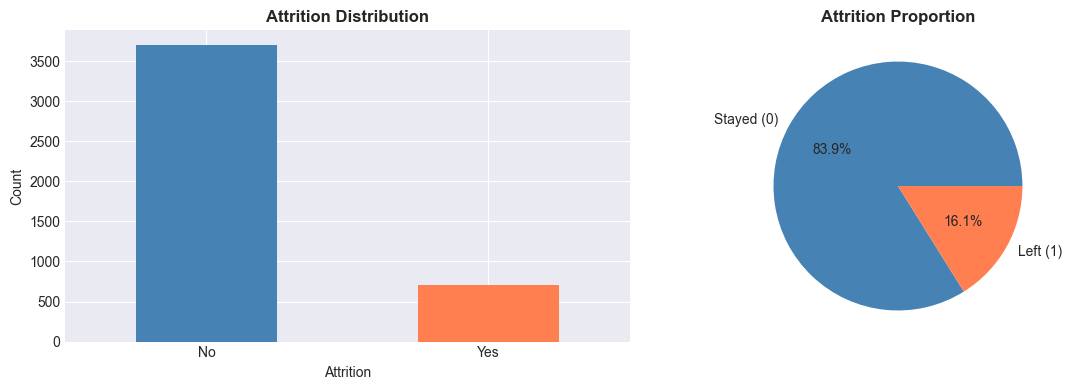


Class imbalance: 5.2:1


In [7]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_engineered['Attrition'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Attrition Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Attrition')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

df_engineered['Attrition_Binary'].value_counts().plot(
    kind='pie', ax=axes[1], autopct='%1.1f%%',
    labels=['Stayed (0)', 'Left (1)'], colors=['steelblue', 'coral']
)
axes[1].set_title('Attrition Proportion', fontweight='bold', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass imbalance: {(df_engineered['Attrition_Binary'] == 0).sum() / (df_engineered['Attrition_Binary'] == 1).sum():.1f}:1")

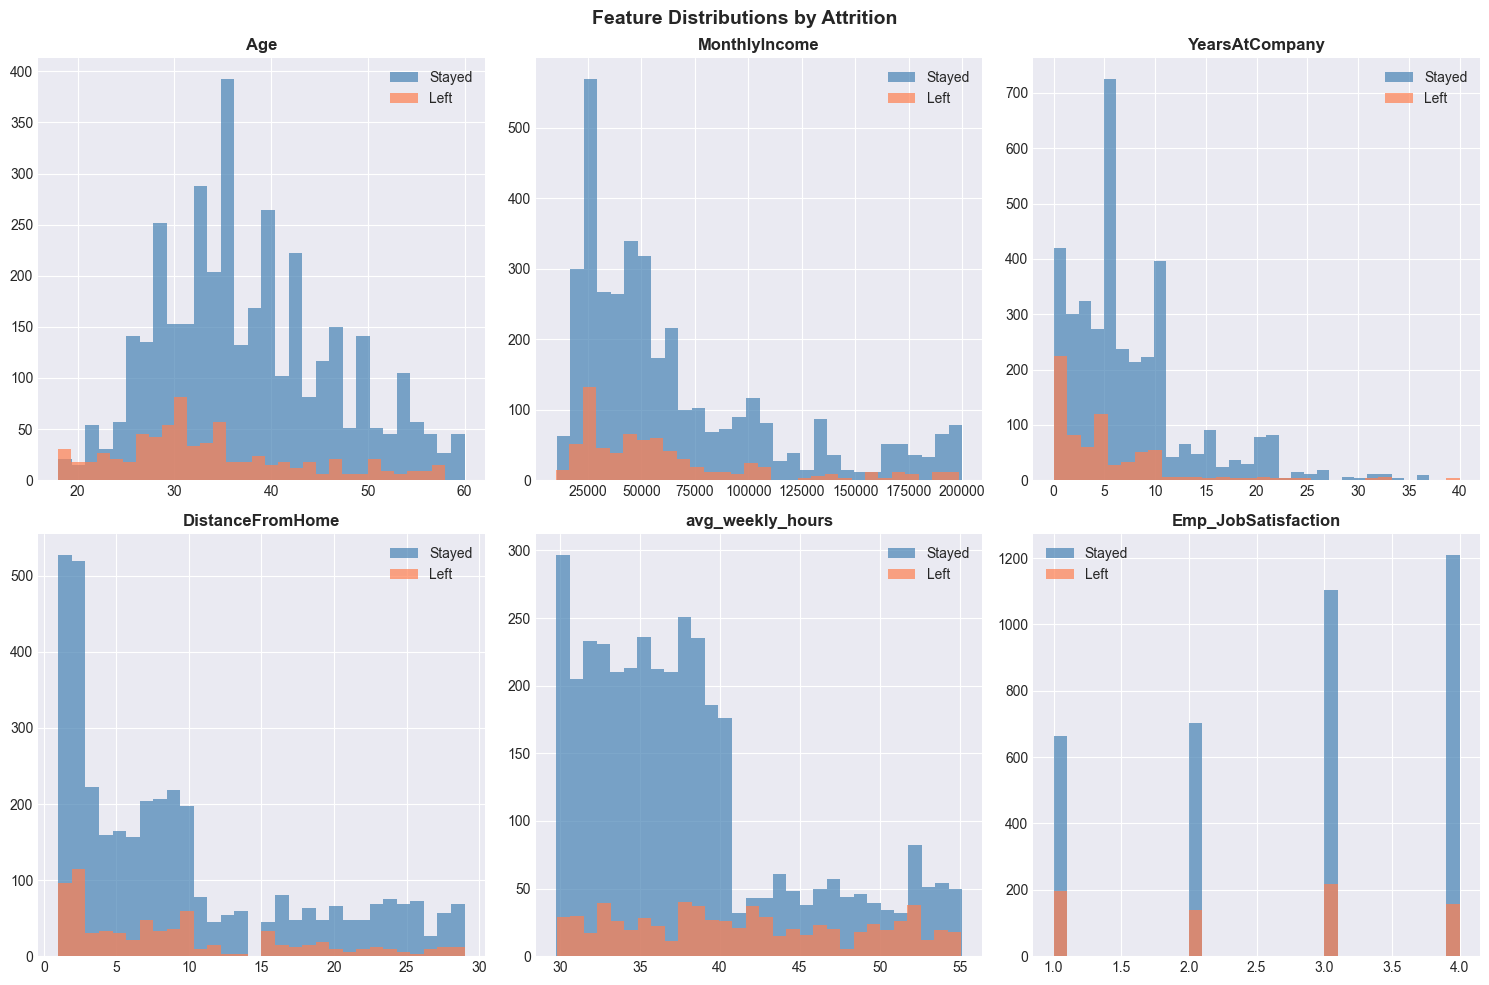

In [8]:
# Key feature distributions by attrition
key_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome', 
                'avg_weekly_hours', 'Emp_JobSatisfaction']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if col in df_engineered.columns:
        df_engineered[df_engineered['Attrition_Binary'] == 0][col].hist(
            ax=axes[idx], alpha=0.7, label='Stayed', bins=30, color='steelblue'
        )
        df_engineered[df_engineered['Attrition_Binary'] == 1][col].hist(
            ax=axes[idx], alpha=0.7, label='Left', bins=30, color='coral'
        )
        axes[idx].set_title(col, fontweight='bold')
        axes[idx].legend()
        axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions by Attrition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

### Correlation Analysis

**What we're doing:**
Measuring linear relationships between features and attrition using Pearson correlation.

**Formula:** r = covariance(X,Y) / (std(X) × std(Y))

**Interpretation:**
- **r > 0**: Feature increases → attrition increases (e.g., overtime)
- **r < 0**: Feature increases → attrition decreases (e.g., tenure)
- **|r| > 0.3**: Strong relationship worth investigating
- **|r| < 0.1**: Weak relationship, may not be useful

**Why this matters:**
- Identifies most predictive features early
- Detects multicollinearity (features that measure same thing)
- Guides feature selection
- Provides business insights before modeling

**Limitations:** Only captures linear relationships; XGBoost will find non-linear patterns too.

Top 15 Positively Correlated Features:
overtime_ratio           0.230371
new_manager              0.205598
avg_daily_hours          0.201688
avg_weekly_hours         0.201688
frequent_overtime        0.200266
min_daily_hours          0.199529
max_daily_hours          0.198823
high_overtime_ratio      0.138488
low_satisfaction         0.137143
overwork_flag            0.135173
salary_per_exp_year      0.122515
job_hopper               0.076902
early_career_switcher    0.074893
hours_x_wlb              0.058272
total_work_days          0.043517
Name: Attrition_Binary, dtype: float64

Top 15 Negatively Correlated Features:
TrainingTimesLastYear         -0.049431
Emp_WorkLifeBalance           -0.062756
company_tenure_ratio          -0.091977
stable_manager                -0.101515
Emp_EnvironmentSatisfaction   -0.102142
Emp_JobSatisfaction           -0.102847
underwork_flag                -0.115315
underutilized                 -0.120794
YearsAtCompany                -0.134392
early_depart

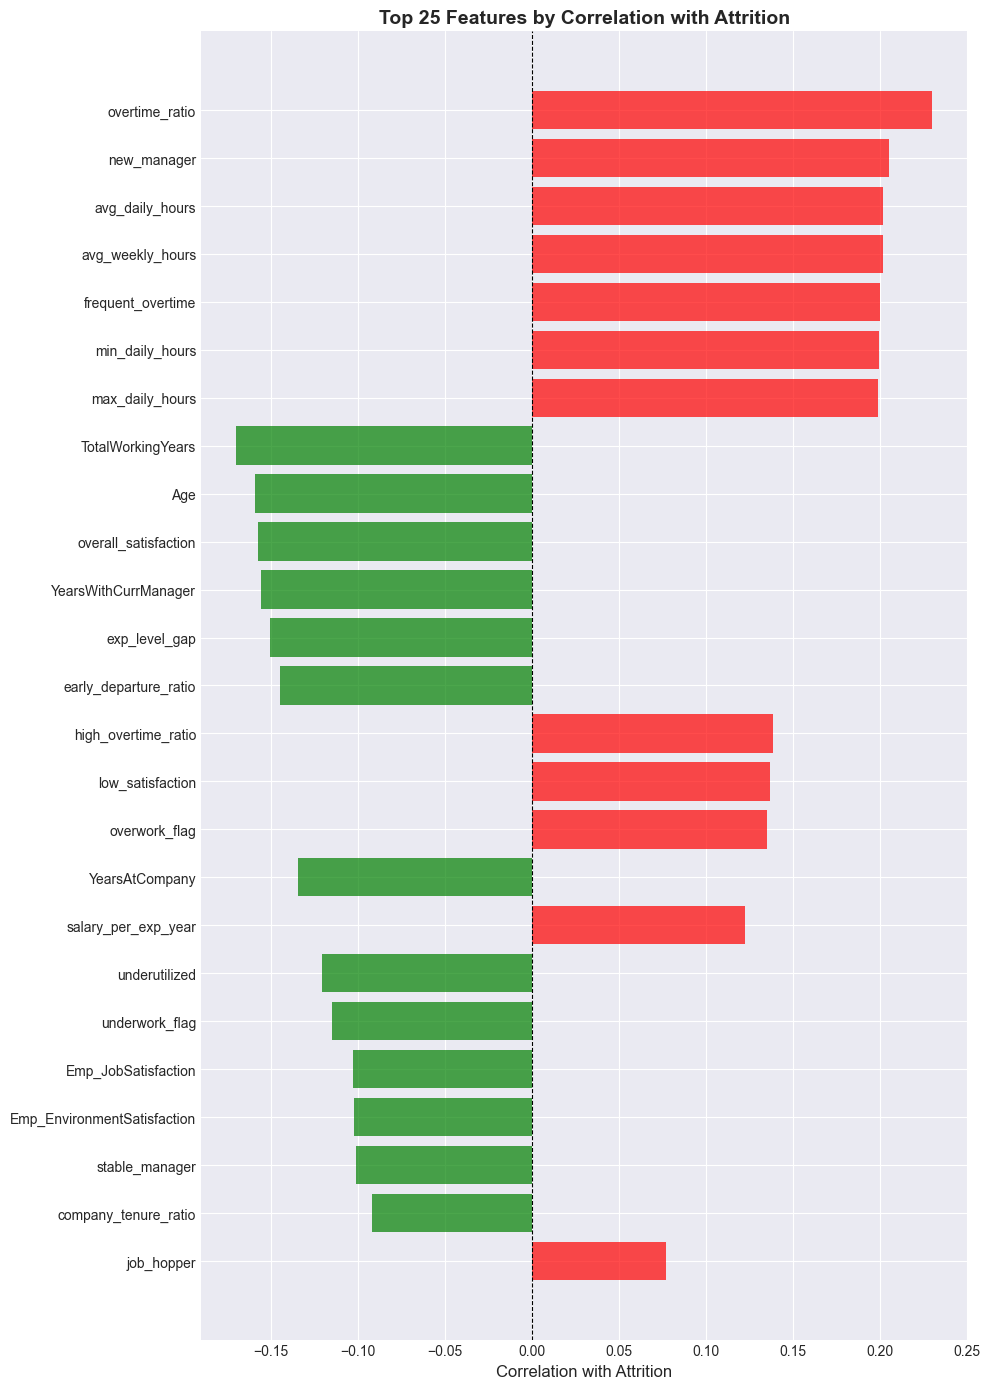

In [9]:
# Get numerical features
numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['EmployeeID', 'EmployeeCount', 'StandardHours']]

# Correlation with target
correlations = df_engineered[numeric_cols].corr()['Attrition_Binary'].drop('Attrition_Binary').sort_values(ascending=False)

print("Top 15 Positively Correlated Features:")
print(correlations.head(15))
print("\nTop 15 Negatively Correlated Features:")
print(correlations.tail(15))

# Visualize
fig, ax = plt.subplots(figsize=(10, 14))
top_features = correlations.abs().sort_values(ascending=False).head(25)
colors = ['red' if correlations[f] > 0 else 'green' for f in top_features.index]
ax.barh(range(len(top_features)), correlations[top_features.index], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index)
ax.set_xlabel('Correlation with Attrition', fontsize=12)
ax.set_title('Top 25 Features by Correlation with Attrition', fontweight='bold', fontsize=14)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Prepare Data for Modeling

In [10]:
# Remove unnecessary columns
exclude_cols = ['EmployeeID', 'Attrition', 'Attrition_Binary', 'EmployeeCount', 'StandardHours', 'Over18']
feature_cols = [col for col in df_engineered.columns if col not in exclude_cols]

X = df_engineered[feature_cols].copy()
y = df_engineered['Attrition_Binary'].copy()

# Identify column types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Total features: {len(feature_cols)}")
print(f"Numerical: {len(numeric_features)}")
print(f"Categorical: {len(categorical_features)}")
print(f"\nCategorical: {categorical_features}")

# Handle missing values
print(f"\nMissing values before: {X.isnull().sum().sum()}")

if numeric_features:
    imputer_num = SimpleImputer(strategy='median')
    X[numeric_features] = imputer_num.fit_transform(X[numeric_features])

if categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X[categorical_features] = imputer_cat.fit_transform(X[categorical_features])

print(f"Missing values after: {X.isnull().sum().sum()}")

# Encode categorical
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\n✓ Encoded {len(categorical_features)} categorical features")
print(f"\nFinal X shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Total features: 63
Numerical: 56
Categorical: 7

Categorical: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'age_group']

Missing values before: 234
Missing values after: 0

✓ Encoded 7 categorical features

Final X shape: (4410, 63)
Target distribution:
Attrition_Binary
0    3699
1     711
Name: count, dtype: int64


## 9. Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain distribution:\n{y_train.value_counts()}")
print(f"Test distribution:\n{y_test.value_counts()}")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

Training set: (3528, 63)
Test set: (882, 63)

Train distribution:
Attrition_Binary
0    2959
1     569
Name: count, dtype: int64
Test distribution:
Attrition_Binary
0    740
1    142
Name: count, dtype: int64

Scale pos weight: 5.20


## 10. Baseline XGBoost Model

###  XGBoost: Extreme Gradient Boosting

**What it is:**
Sequential ensemble of decision trees where each tree corrects errors from previous trees.

**How it works:**
1. Start with weak prediction (mean)
2. Build Tree 1: focus on high-error samples
3. Build Tree 2: correct Tree 1's mistakes
4. Repeat for n_estimators trees
5. Final prediction = weighted sum of all trees

**Key parameters:**
- `n_estimators=100`: Number of trees (more = complex)
- `max_depth=6`: Tree depth (controls overfitting)
- `learning_rate=0.1`: How much each tree contributes
- `scale_pos_weight=5.2`: **CRITICAL** for handling 5.2:1 class imbalance

**Why XGBoost?**
- Handles non-linear relationships
- Robust to outliers and missing values
- Feature importance built-in
- State-of-the-art performance on tabular data

**Loss function:** Log loss (cross-entropy) penalizes confident wrong predictions

In [12]:
print("Training baseline XGBoost...\n")

xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_baseline.fit(X_train, y_train)

y_pred_baseline = xgb_baseline.predict(X_test)
y_proba_baseline = xgb_baseline.predict_proba(X_test)[:, 1]

print("="*60)
print("BASELINE XGBOOST RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"\nROC AUC: {roc_auc_score(y_test, y_proba_baseline):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_baseline):.4f}")

Training baseline XGBoost...

BASELINE XGBOOST RESULTS

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       740
           1       0.96      0.96      0.96       142

    accuracy                           0.99       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.99      0.99      0.99       882


ROC AUC: 0.9885
F1 Score: 0.9577


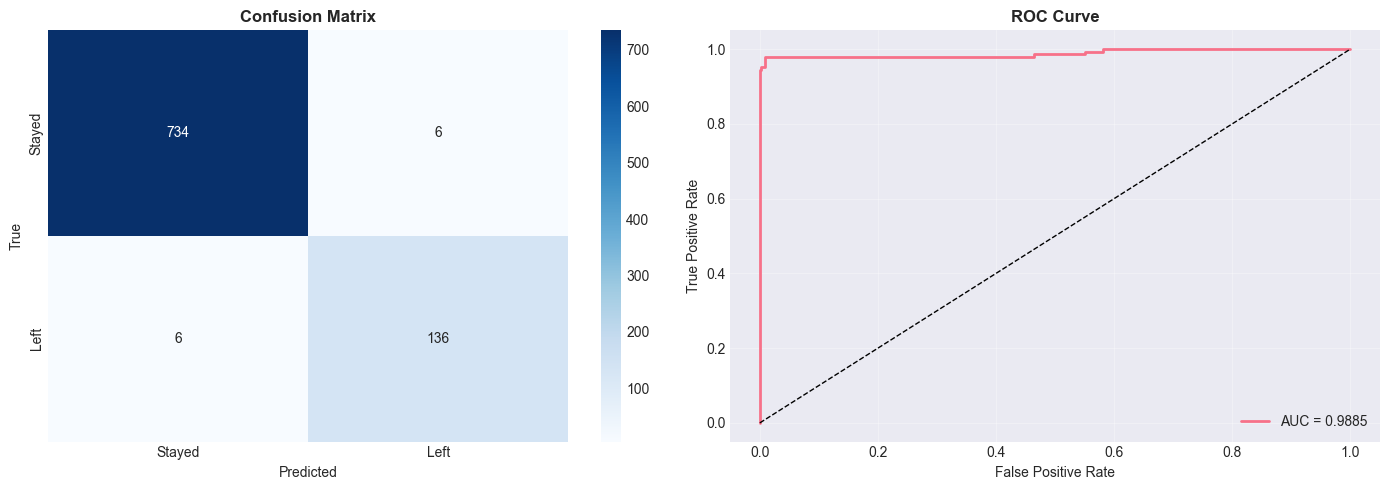

In [13]:
# Confusion Matrix and ROC Curve
cm = confusion_matrix(y_test, y_pred_baseline)
fpr, tpr, _ = roc_curve(y_test, y_proba_baseline)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# ROC Curve
axes[1].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc_score(y_test, y_proba_baseline):.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Feature Importance

Top 20 Most Important Features:
                    Feature  Importance
             overtime_ratio    0.114496
          TotalWorkingYears    0.043723
      early_career_switcher    0.034551
              MaritalStatus    0.034257
       overall_satisfaction    0.030343
            avg_daily_hours    0.030037
             YearsAtCompany    0.029904
            max_daily_hours    0.029037
        Emp_JobSatisfaction    0.028878
Emp_EnvironmentSatisfaction    0.028411
                        Age    0.027613
       YearsWithCurrManager    0.027539
       company_tenure_ratio    0.026124
             EducationField    0.025734
    YearsSinceLastPromotion    0.023349
        promotion_lag_ratio    0.022185
      TrainingTimesLastYear    0.020166
        salary_per_exp_year    0.019368
         NumCompaniesWorked    0.019082
                    JobRole    0.018905


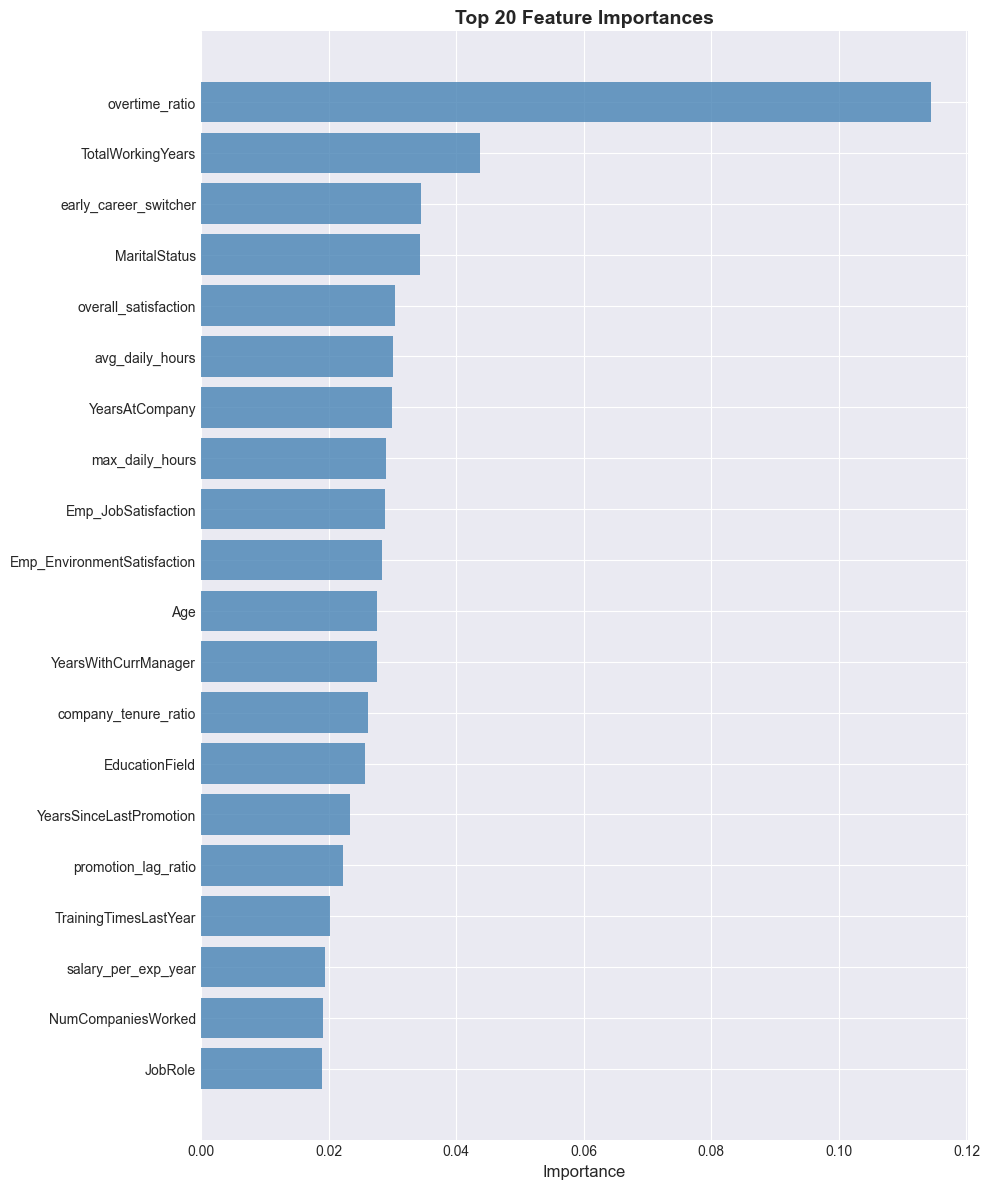

In [14]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_baseline.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

plt.figure(figsize=(10, 12))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Hyperparameter Tuning

###  Hyperparameter Tuning with RandomizedSearchCV

**What we're optimizing:**
Finding the best combination of model parameters to maximize ROC AUC.

**Parameters being tuned:**
- `n_estimators`: Number of trees [100, 200, 300]
- `max_depth`: Tree depth [4, 6, 8]
- `learning_rate`: Step size [0.01, 0.05, 0.1]
- `subsample`: % of data per tree [0.7-0.9]
- `colsample_bytree`: % of features per tree [0.7-0.9]
- `gamma`: Minimum loss reduction to split [0-0.3]
- `min_child_weight`: Min samples in leaf [1, 3, 5]
- `reg_alpha/lambda`: L1/L2 regularization (prevents overfitting)

**The process:**
1. Randomly sample 30 parameter combinations
2. For each combination: run 5-fold cross-validation
3. Track which combination achieves highest average ROC AUC
4. **Total models trained:** 30 combinations × 5 folds = 150 models

**Why Random Search > Grid Search:**
- Grid would test ~80,000 combinations → days of computation
- Random tests 30 combinations → minutes
- Research shows random finds near-optimal solutions in ~10% of time

In [15]:
print("Hyperparameter tuning (this will take a few minutes)...\n")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    ),
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X_train, y_train)

print("\n" + "="*60)
print("TUNING RESULTS")
print("="*60)
print(f"\nBest CV ROC AUC: {xgb_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in xgb_search.best_params_.items():
    print(f"  {param}: {value}")

Hyperparameter tuning (this will take a few minutes)...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

TUNING RESULTS

Best CV ROC AUC: 0.9860

Best Parameters:
  subsample: 0.9
  reg_lambda: 1
  reg_alpha: 0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 8
  learning_rate: 0.1
  gamma: 0.3
  colsample_bytree: 0.9


In [16]:
# Evaluate tuned model
xgb_tuned = xgb_search.best_estimator_

y_pred_tuned = xgb_tuned.predict(X_test)
y_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

print("="*60)
print("TUNED XGBOOST RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))
print(f"\nROC AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_tuned):.4f}")

TUNED XGBOOST RESULTS

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.97      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882


ROC AUC: 0.9949
F1 Score: 0.9857


## 13. Threshold Optimization

###  Threshold Optimization for F1 Score

**The problem:**
XGBoost outputs probabilities (0.0 to 1.0), but we need binary predictions (0 or 1).

Default threshold = 0.5, but for imbalanced data, this might not be optimal!

**What we're doing:**
Testing thresholds from 0.1 to 0.9, calculating F1 score for each.

**The trade-off:**
```
Low threshold (0.3):  High Recall, Low Precision  → Catch more leavers, more false alarms
Optimal (0.45):       Balanced F1 Score            → Best overall performance
High threshold (0.7): Low Recall, High Precision   → Miss leavers, fewer false alarms
```

**F1 Score formula:**
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```

**Business decision:**
- **High-risk tolerance**: Use lower threshold (catch all potential leavers)
- **Low-risk tolerance**: Use higher threshold (only act on confident predictions)
- **Balanced approach**: Use optimal threshold from F1 maximization

Optimal Threshold: 0.45
Best F1 Score: 0.9893


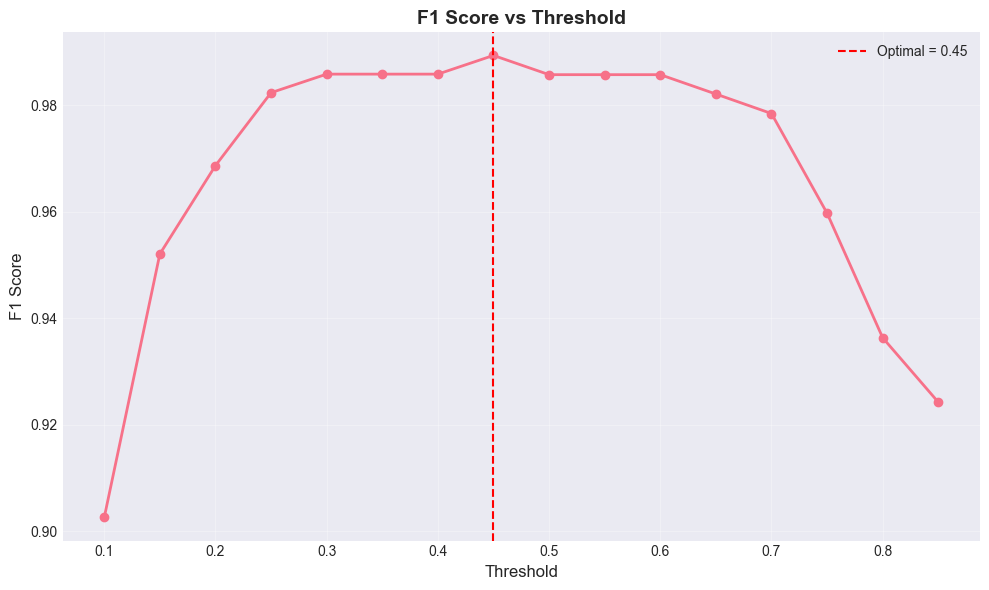


OPTIMAL THRESHOLD RESULTS (0.45)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      0.98      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



In [17]:
# Find optimal threshold
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = [f1_score(y_test, (y_proba_tuned >= t).astype(int)) for t in thresholds]

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1 = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, marker='o')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal = {optimal_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_pred_optimal = (y_proba_tuned >= optimal_threshold).astype(int)

print("\n" + "="*60)
print(f"OPTIMAL THRESHOLD RESULTS ({optimal_threshold:.2f})")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

## 14. Cross-Validation

###  K-Fold Cross-Validation (K=5)

**What it is:**
Splitting training data into 5 parts, training on 4, testing on 1, rotating through all combinations.

**Visual:**
```
Fold 1: [TEST] [TRAIN] [TRAIN] [TRAIN] [TRAIN]
Fold 2: [TRAIN] [TEST] [TRAIN] [TRAIN] [TRAIN]
Fold 3: [TRAIN] [TRAIN] [TEST] [TRAIN] [TRAIN]
Fold 4: [TRAIN] [TRAIN] [TRAIN] [TEST] [TRAIN]
Fold 5: [TRAIN] [TRAIN] [TRAIN] [TRAIN] [TEST]
```

**Why we do this:**
- **Single train-test split:** Could get lucky/unlucky with the split
- **5-fold CV:** Averages performance across 5 different splits
- **Result:** More reliable estimate of true model performance

**Output:**
```
CV Scores: [0.842, 0.839, 0.846, 0.840, 0.842]
Mean: 0.842 ± 0.002
```
- **Mean**: Expected performance on unseen data
- **Std**: Consistency (low std = stable model)

**Why Stratified K-Fold:**
Each fold maintains 16% attrition rate → fair evaluation across all folds

In [18]:
print("5-fold cross-validation...\n")

cv_scores = cross_val_score(
    xgb_tuned, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print(f"CV ROC AUC scores: {cv_scores}")
print(f"\nMean: {cv_scores.mean():.4f}")
print(f"Std: {cv_scores.std():.4f}")
print(f"95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, "
      f"{cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

5-fold cross-validation...

CV ROC AUC scores: [0.97452881 0.98321183 0.97866287 0.97981942 0.98971413]

Mean: 0.9812
Std: 0.0051
95% CI: [0.9712, 0.9912]


## 15. Final Summary

In [19]:
# Model comparison
comparison = pd.DataFrame({
    'Model': ['Baseline XGBoost', 'Tuned XGBoost', 'Optimal Threshold'],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba_baseline),
        roc_auc_score(y_test, y_proba_tuned),
        roc_auc_score(y_test, y_proba_tuned)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_tuned),
        f1_score(y_test, y_pred_optimal)
    ]
})

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"\nDataset: {len(df_engineered)} employees, {X.shape[1]} features")
print(f"Attrition rate: {(y == 1).mean():.2%}")
print(f"\nModel Comparison:")
print(comparison.to_string(index=False))
print(f"\nCross-validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\nTop 5 Features:")
for _, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")
print("\n" + "="*60)


FINAL MODEL SUMMARY

Dataset: 4410 employees, 63 features
Attrition rate: 16.12%

Model Comparison:
            Model  ROC AUC  F1 Score
 Baseline XGBoost 0.988523  0.957746
    Tuned XGBoost 0.994909  0.985714
Optimal Threshold 0.994909  0.989324

Cross-validation: 0.9812 ± 0.0051

Top 5 Features:
  overtime_ratio: 0.1145
  TotalWorkingYears: 0.0437
  early_career_switcher: 0.0346
  MaritalStatus: 0.0343
  overall_satisfaction: 0.0303



## 16. Save Model

In [20]:
import pickle

# Save model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_tuned, f)

# Save artifacts
feature_importance.to_csv('feature_importance.csv', index=False)
comparison.to_csv('model_comparison.csv', index=False)

# Save metadata
metadata = {
    'optimal_threshold': optimal_threshold,
    'scale_pos_weight': scale_pos_weight,
    'feature_names': X.columns.tolist(),
    'label_encoders': {k: v.classes_.tolist() for k, v in label_encoders.items()}
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✓ Files saved:")
print("  - xgboost_model.pkl")
print("  - feature_importance.csv")
print("  - model_comparison.csv")
print("  - model_metadata.pkl")

✓ Files saved:
  - xgboost_model.pkl
  - feature_importance.csv
  - model_comparison.csv
  - model_metadata.pkl
